# Recommender ChatBot: Update Users and Items embeddings using DeepFM model

Generate users/items embeddings using DeepFM collaborative filtering model Then store embeddings into a chromadb database.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
BASE_PATH    = '../..'
LIB_PATH     = f'{BASE_PATH}/lib'
API_PATH     = f'{BASE_PATH}/chat-bot-api'

In [3]:
import sys
sys.path.append(LIB_PATH)
sys.path.append(API_PATH)


import torch
import pytorch_common
import pytorch_common.util as pu
import util as ut
import os

import rest
import pandas as pd

import service as srv
import os
import pytorch_common.util as pu
import rest
import pandas as pd
import torch
import data.dataset as ds
import data as dt
import logging
import util as ut
from models import EntityEmb
from bunch import Bunch 
import logging
import sys
import seaborn as sns
from data.plot import describe_num_var

2024-02-12 17:49:06.695604: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-12 17:49:07.104242: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-02-12 17:49:07.465845: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-12 17:49:07.475657: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GP

<Figure size 640x480 with 0 Axes>

## Setup

In [4]:
pu.LoggerBuilder().on_console().build()

<RootLogger root (INFO)>

In [5]:
import pytorch_common
pytorch_common.__version__

'0.3.8'

In [6]:
torch.__version__

'2.1.2+cu118'

In [7]:
pu.set_device_name('gpu')

pu.get_device(), torch.cuda.is_available()

(device(type='cuda', index=0), True)

In [8]:
ut.set_seed(42)

In [9]:
os.environ['TMP_PATH']         = f'{BASE_PATH}/tmp'
os.environ['DATASET_PATH']     = f'{BASE_PATH}/datasets'
os.environ['WEIGHTS_PATH']     = f'{BASE_PATH}/weights'
os.environ['METRICS_PATH']     = f'{BASE_PATH}/metrics'
os.environ['MONGODB_URL']      = 'mongodb://0.0.0.0:27017'
os.environ['MONGODB_DATABASE'] = 'chatbot'
os.environ['CHROMA_HOST']      = '0.0.0.0'
os.environ['CHROMA_PORT']      = '9090'


from app_context import AppContext

In [10]:
def to_df(items, distances):
    items_df = pd.DataFrame.from_records([i.dict(exclude_none=True) for i in items])
    items_df['distance'] = distances
    return items_df.loc[:, ~items_df.columns.isin(['embedding'])]

In [18]:
async def similars(content, limit):
    items, distances = await ctx.item_service.find_by_content(content)
    items_df = to_df(items, distances)

    print(items_df.iloc[0,:].title)
    
    item  = ctx.items_cf_emb_repository.find_by_id(items_df.iloc[0,:].id)


    similars = ctx.items_cf_emb_repository.find_similars_by_id(
        item.id,
        limit=limit,
    )

    similars_df = pd.DataFrame(
        data={
            'id'       : [str(i) for i in similars.ids],
            'distance' : similars.distances
        }
    )

    similar_items = await ctx.item_service \
        .find_by_ids([str(s) for s in similars.ids])


    similar_items_df = pd.DataFrame \
        .from_records([i.dict(exclude_none=True) for i in similar_items])


    similar_items_df = similar_items_df \
        .merge(similars_df, on=['id'])[['distance', 'rating', 'id', 'title', 'genres', 'release']] \
        .sort_values(by=['distance'])

    return similar_items_df


def filter_by_geners(similar_items_df, genres):
    genres = set(genres)

    genres_similar_items_df = similar_items_df[similar_items_df.genres.apply(lambda x: genres.issubset(set(x))) ]
    
    return genres_similar_items_df \
        .sort_values(by=['distance'])

## Run Job

In [11]:
ctx = AppContext()

2024-02-12 17:49:09,237 - INFO - Load pretrained SentenceTransformer: all-mpnet-base-v2
2024-02-12 17:49:09,782 - INFO - Use pytorch device: cuda
2024-02-12 17:49:09,784 - INFO - Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.
2024-02-12 17:49:09,804 - INFO - Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.


In [12]:
api_client      = rest.RecChatBotV1ApiClient()
interactions_df = pd.DataFrame(api_client.interactions())

logging.info(interactions_df.shape)

data_splitter = ds.TrainTestSplitter(
  n_min_interactions = 20,
  test_size          = 0.1,
  cols               = Bunch(
    order_col   = 'timestamp',
    user_id     = 'user_id',
    item_id     = 'item_id',
    rating      = 'rating',
    rating_mean = 'rating_mean',
    rating_norm = 'rating_norm' 
  )
)

train_set, test_set, rating_mean_df, rating_std = data_splitter(interactions_df)


# Generate sequences....
user_sequencer = dt.Sequencer('user_id', 'user_seq')
item_sequencer = dt.Sequencer('item_id', 'item_seq')

train_set = user_sequencer.perform(train_set)
train_set = item_sequencer.perform(train_set)

test_set = user_sequencer.perform(test_set)
test_set = item_sequencer.perform(test_set)

2024-02-12 17:49:15,029 - INFO - (190025, 4)
2024-02-12 17:49:17,062 - INFO - Train: 71.28 % - Test: 8.13 %


In [13]:
model_loader = srv.DeepFMLoader(
    weights_path          = os.environ['WEIGHTS_PATH'],
    metrics_path          = os.environ['METRICS_PATH'],
    tmp_path              = os.environ['TMP_PATH'],
    user_seq_col          = 'user_seq',
    item_seq_col          = 'item_seq',
    update_period_in_min  = 1,
    params              = Bunch({
        'model': Bunch({
            'units_per_layer'   : [20, 1],
            'dropout'           : 0.25,
            'embedding_size'    : 50,
        }),
        'train': Bunch({
            'lr'         : 0.001,
            'lr_factor'  : 0.1,
            'lr_patience': 6,
            'epochs'     : 9,
            'n_workers'  : 24,
            'batch_size' : 2048,
            'eval_percent': 0.15
        }),
        'metrics': Bunch({
            'n_samples'  : 250,
            'batch_size' : 2000
        })
    })
)

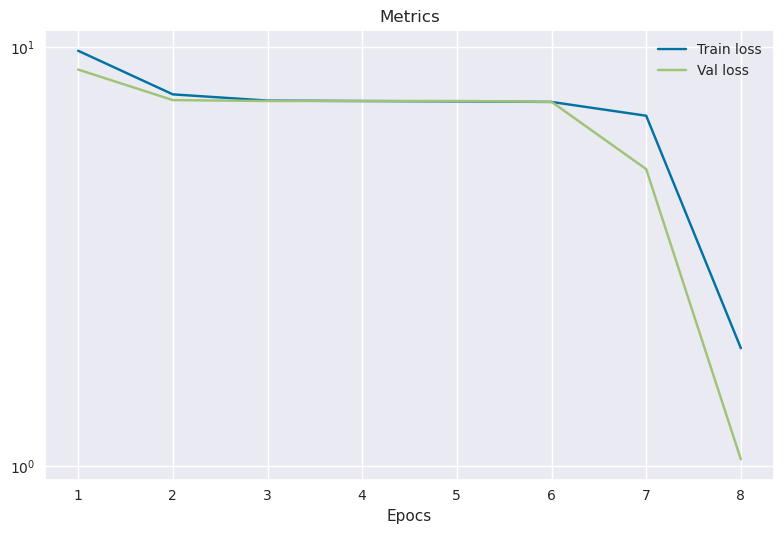

2024-02-12 17:50:31,358 - INFO - {'time': '0:00:07.26', 'epoch': 9, 'train_loss': 1.065118440051577, 'val_loss': 1.0835384130477905, 'lr': 0.001}


Computing metrics using validation set:   0%|          | 0/250 [00:00<?, ?it/s]

Ordered by mAP@5(4,5):


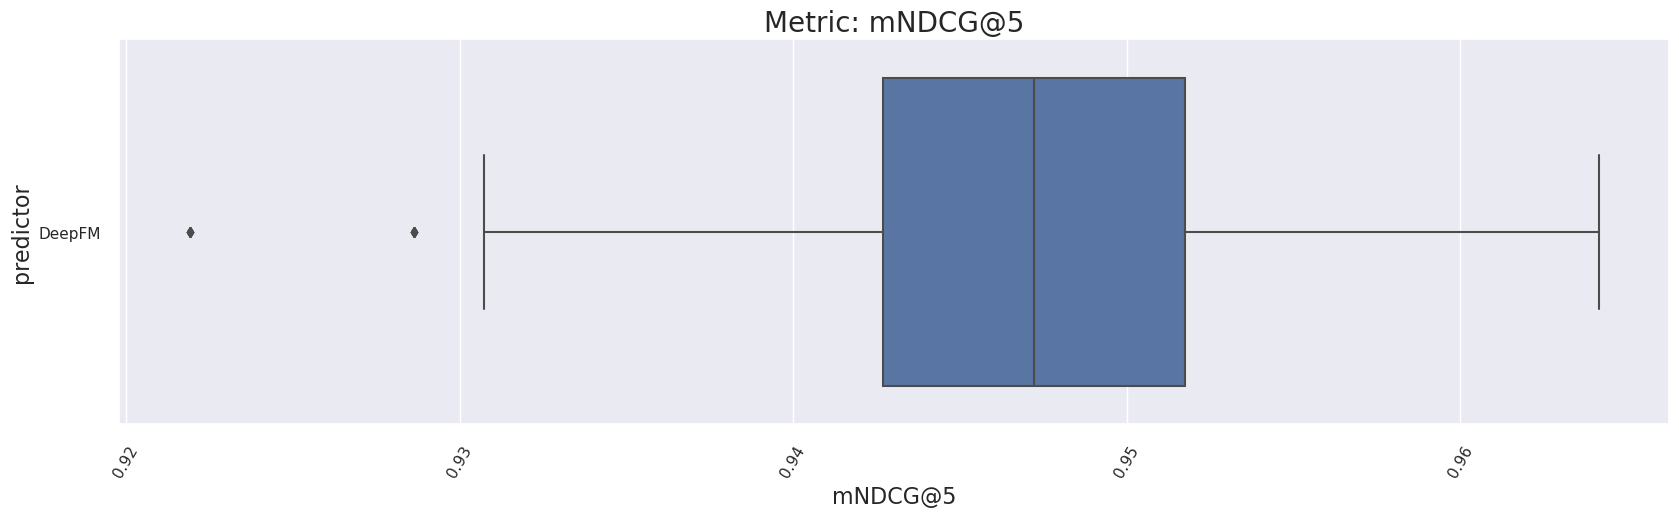

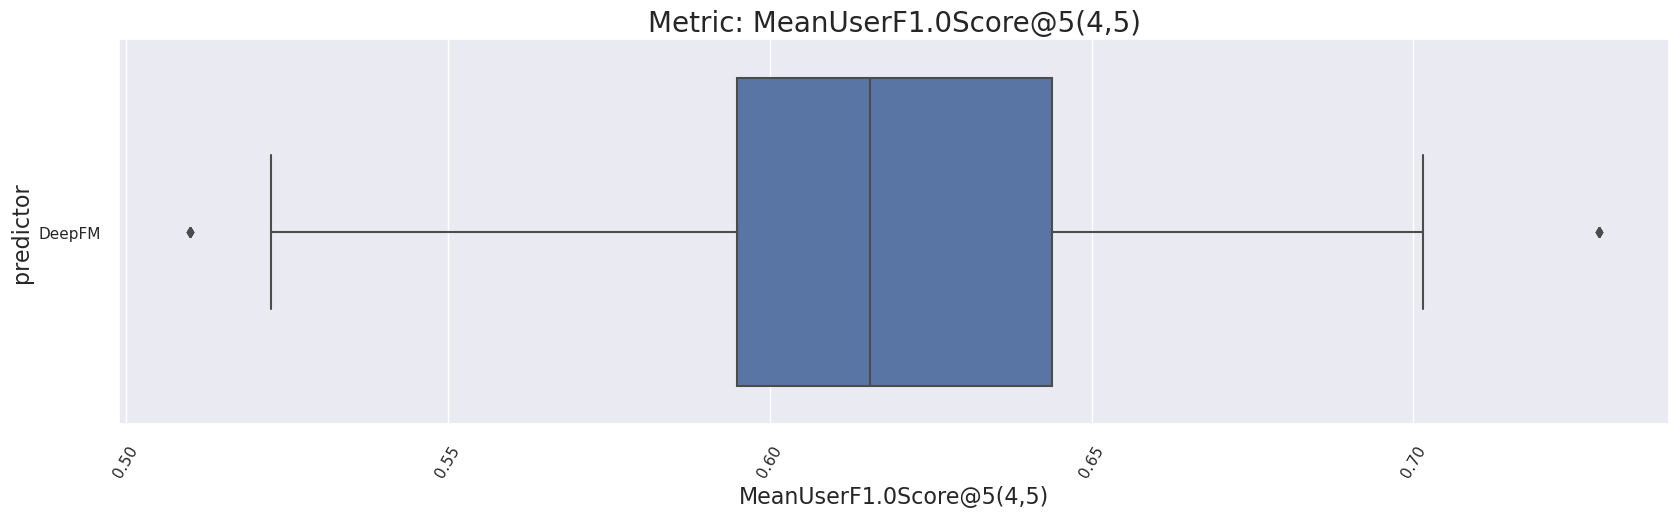

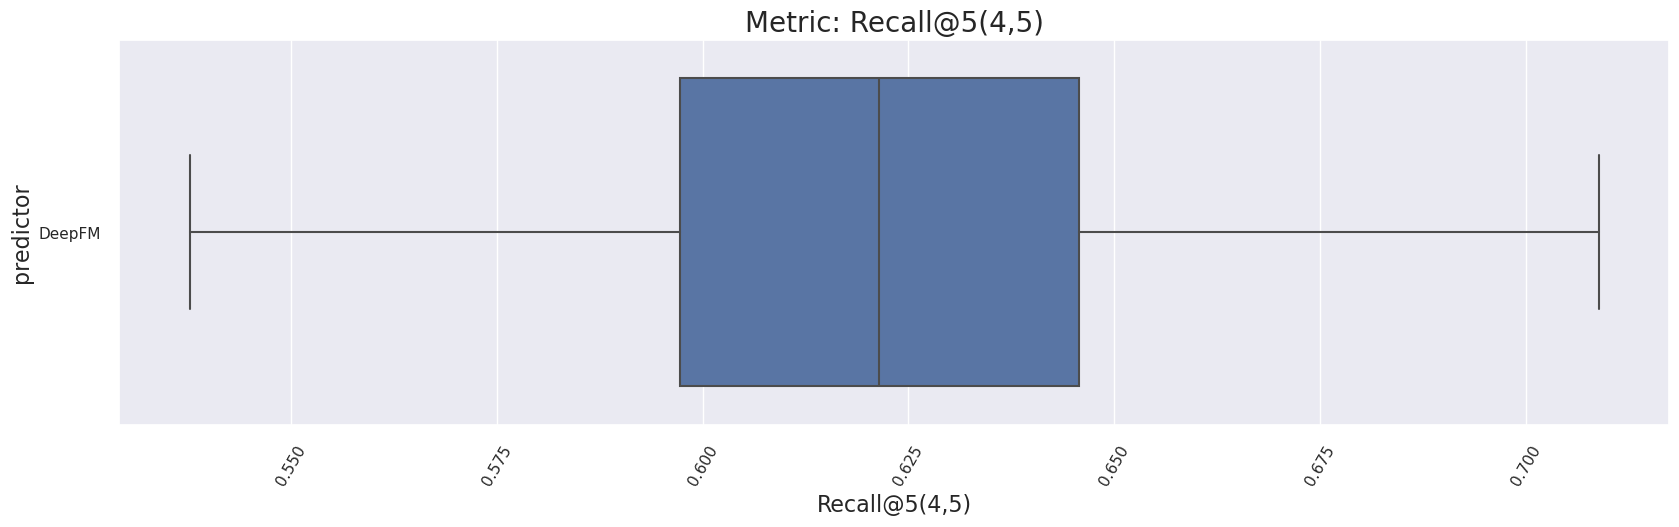

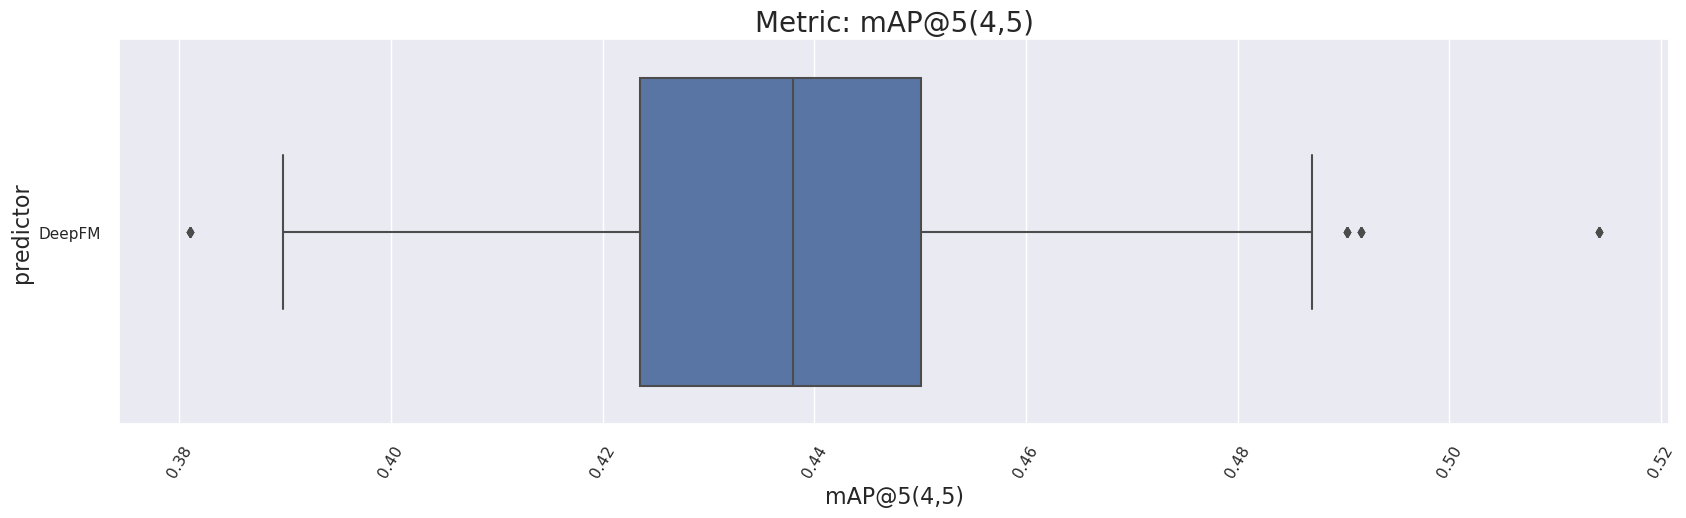

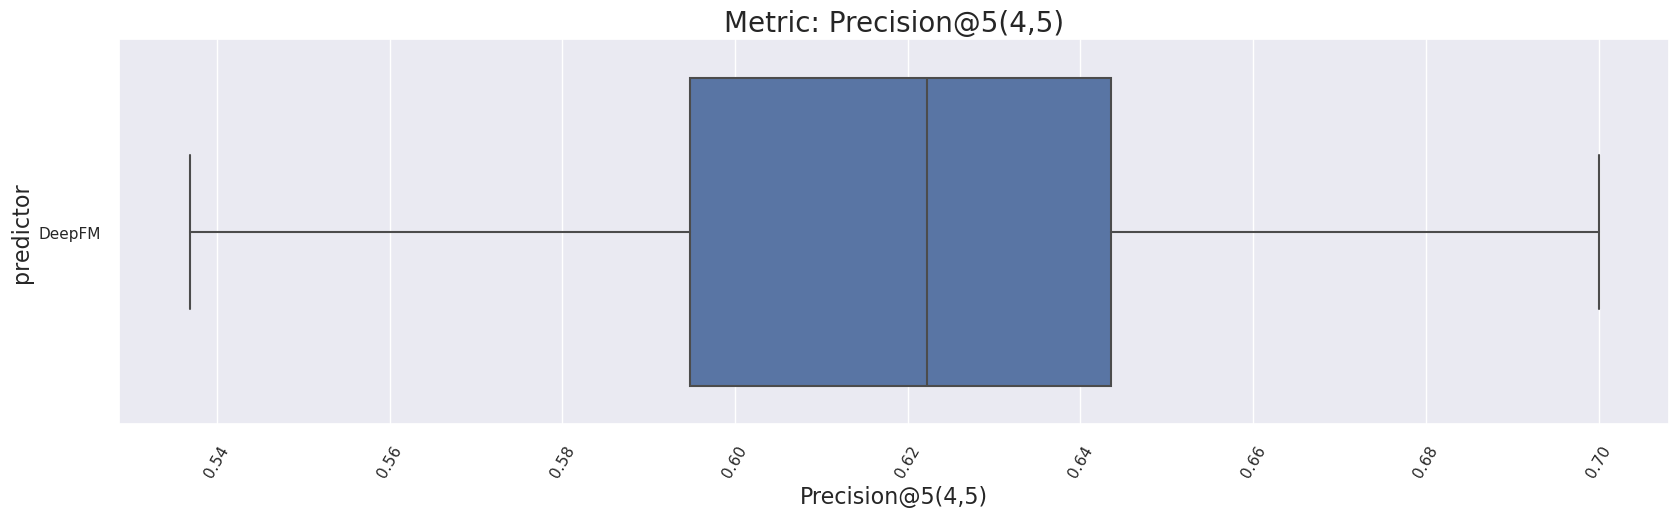

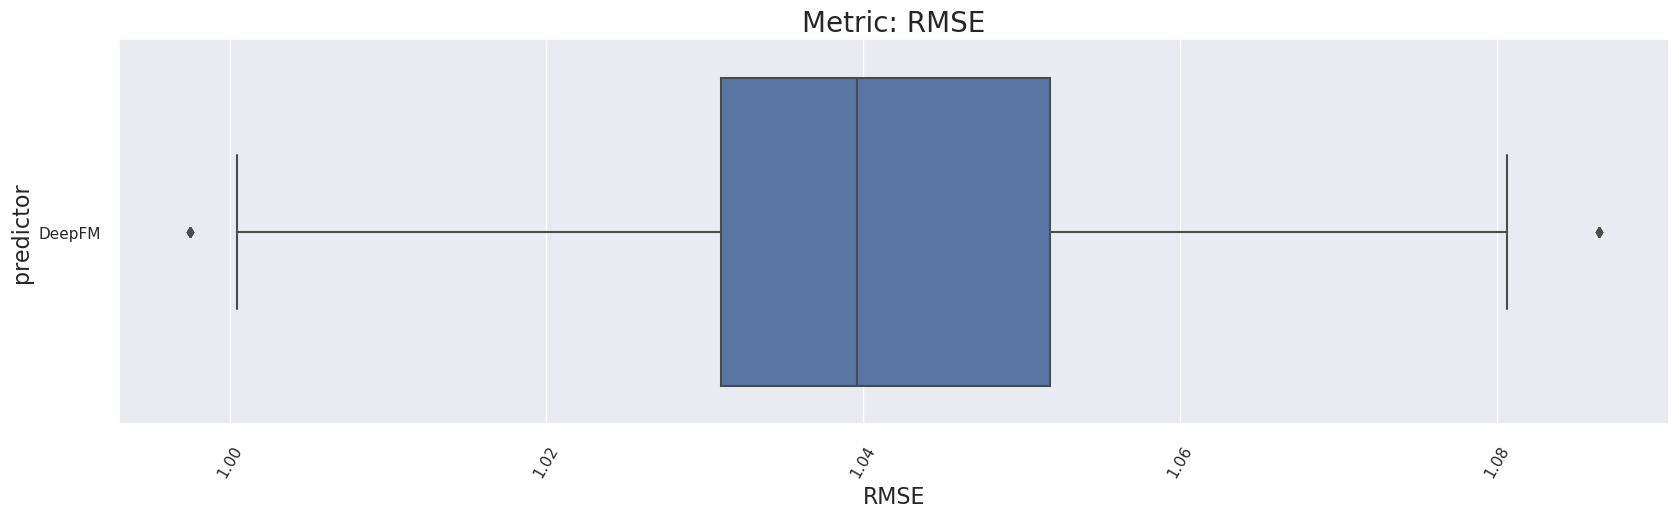

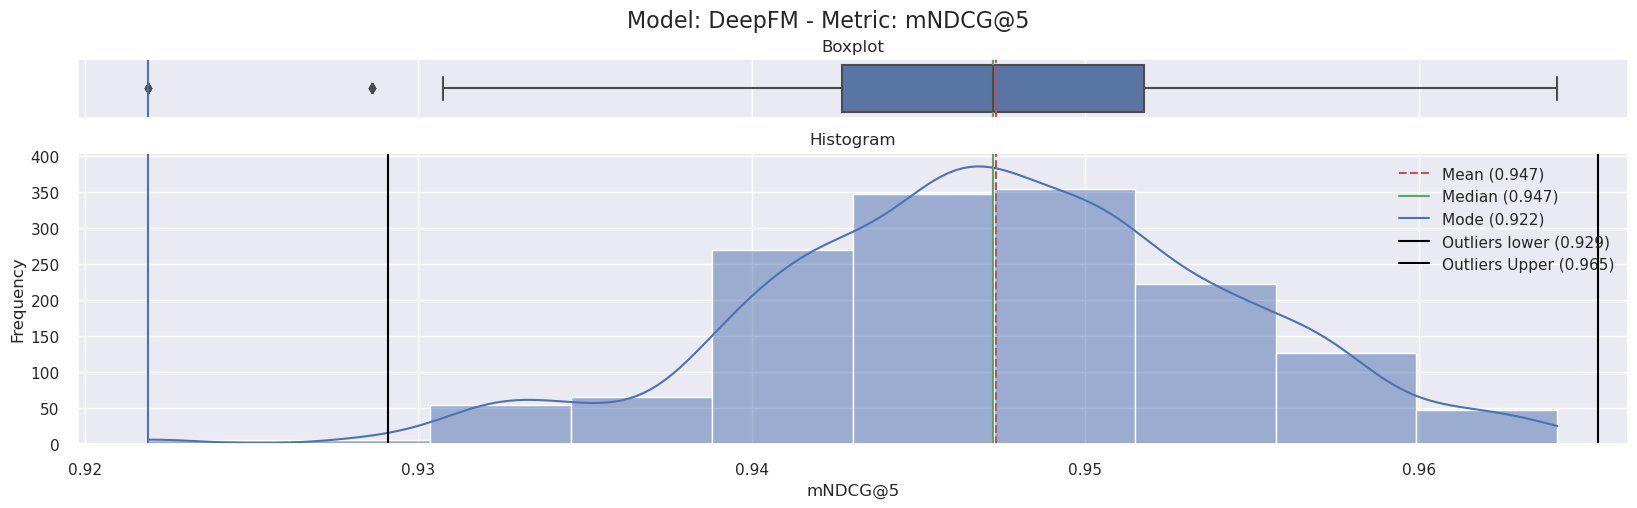

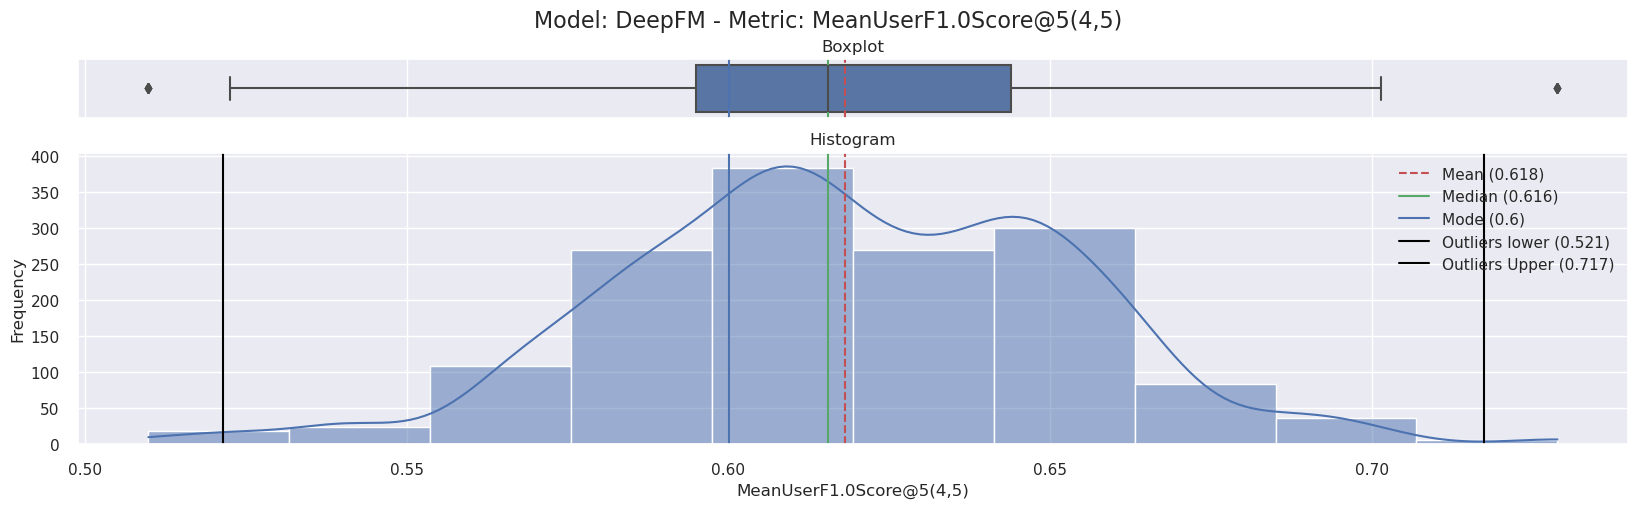

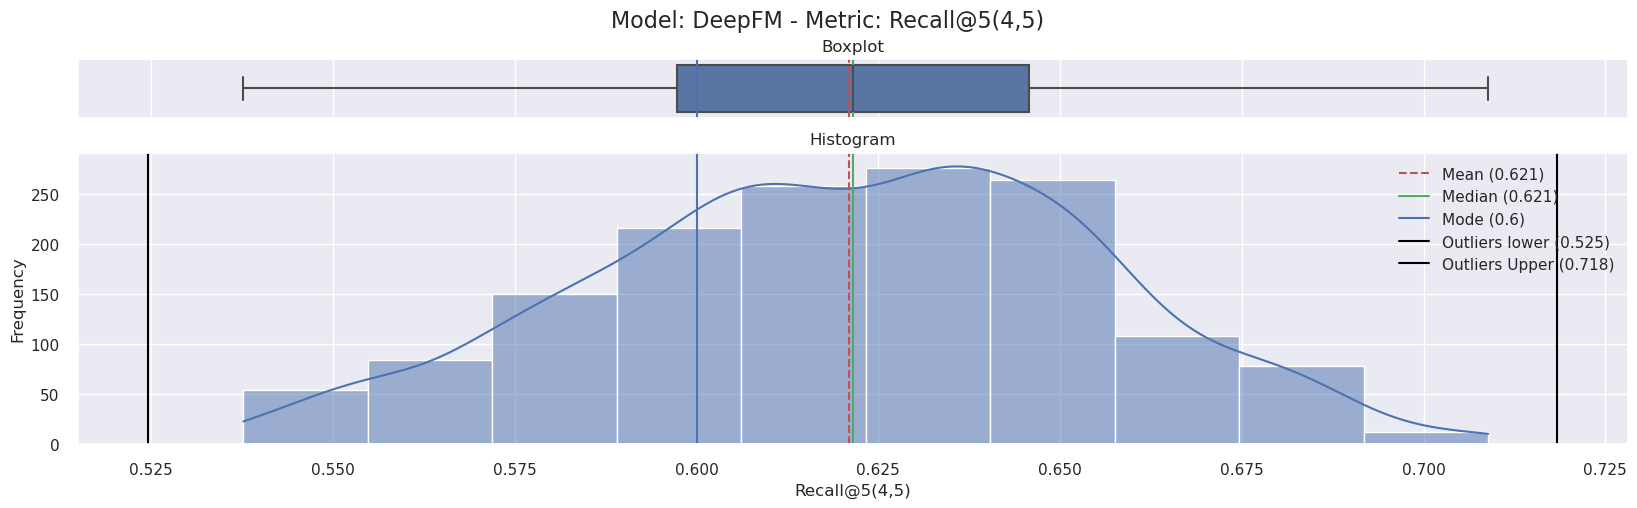

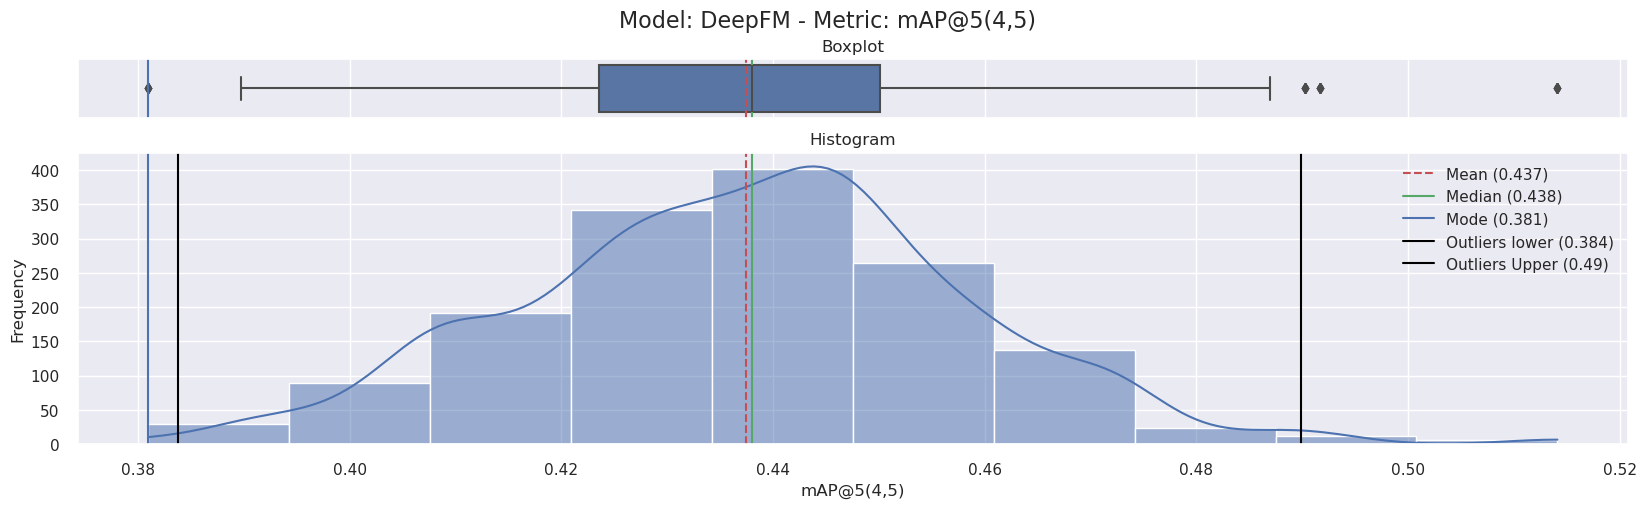

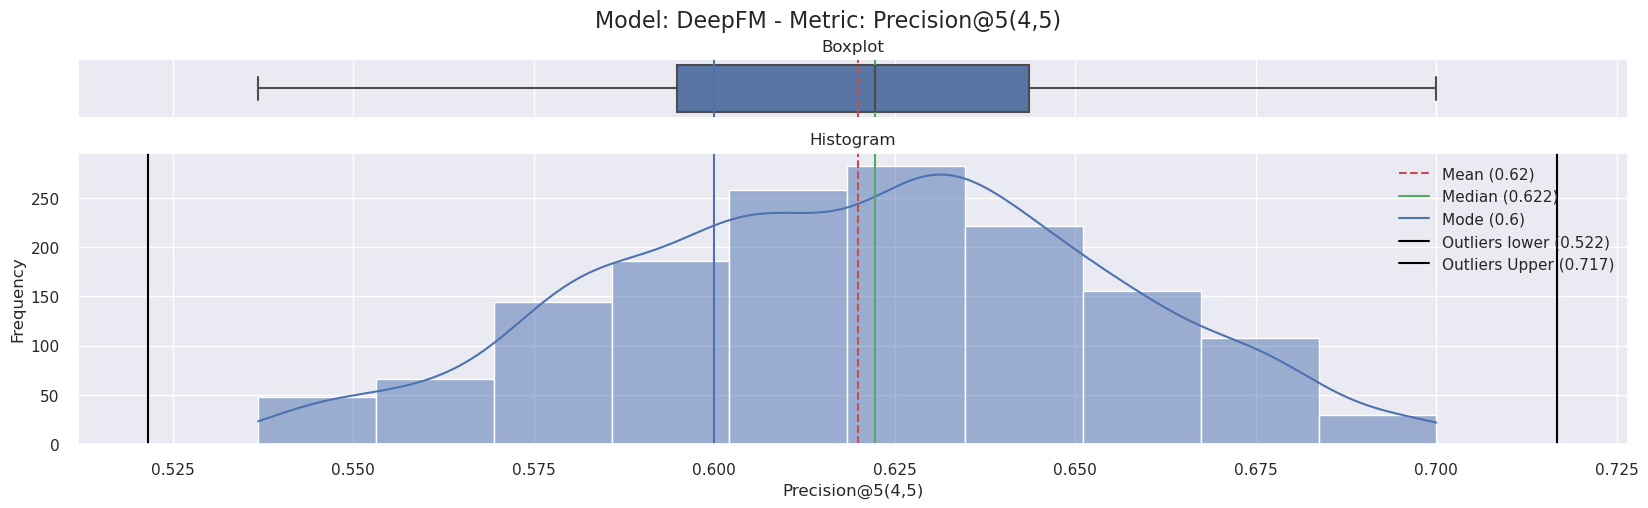

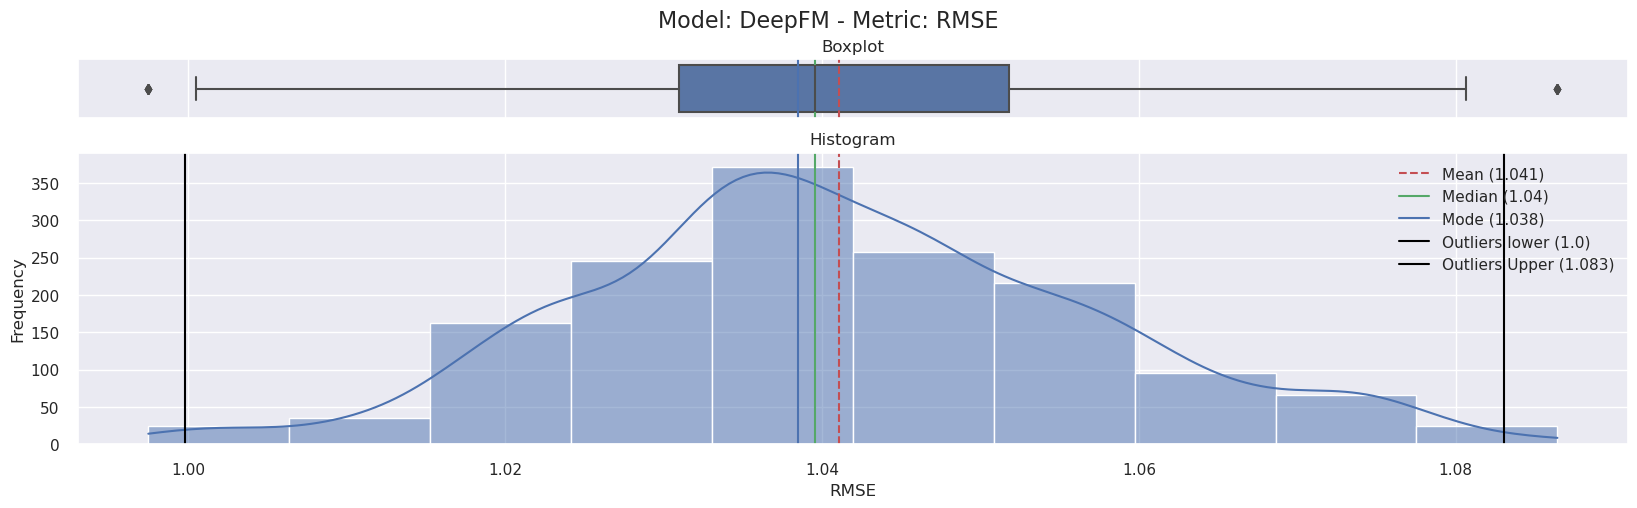

In [14]:
model, params = model_loader.load(train_set, test_set)

In [15]:
[user_embeddings, item_embeddings] = model.embedding.feature_embeddings

def to_entity_embs(df, seq_col, id_col, embeddings):
    seq_to_id = ut.to_dict(df, seq_col, id_col)
    return [
        EntityEmb(
            id  = str(id),
            emb = embeddings[seq].tolist()
        )
          for seq, id in seq_to_id.items()
    ]

user_embs = train_set.pipe(to_entity_embs, 'user_seq', 'user_id', user_embeddings)
ctx.users_cf_emb_repository.upsert_many(user_embs)

item_embs = train_set.pipe(to_entity_embs, 'item_seq', 'item_id', item_embeddings)
ctx.items_cf_emb_repository.upsert_many(item_embs)

2024-02-12 17:51:09,787 - INFO - Get feature 0 embeddings [1736, 50]. Detail: Embeddings from 0 to 1735 from weights [16222, 50]
2024-02-12 17:51:09,788 - INFO - Get feature 1 embeddings [14486, 50]. Detail: Embeddings from 1736 to 16221 from weights [16222, 50]


Insert embeddings into "users_cf" collection (chroma-db):   0%|          | 0/1736 [00:00<?, ?it/s]

Insert embeddings into "items_cf" collection (chroma-db):   0%|          | 0/14486 [00:00<?, ?it/s]

In [16]:
test_set[train_set['user_id'].str.contains('@')].head()

/var/tmp/ipykernel_1409167/3875379249.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  test_set[train_set['user_id'].str.contains('@')].head()


,user_id,item_id,rating,timestamp,rating_mean,rating_norm,user_seq,item_seq
2459,131347,109848,2.0,2017-06-09 04:39:47,2.380831,-0.365992,27,379
4563,103902,48385,5.0,2012-07-10 07:12:54,4.360000,0.615062,322,683
887,118876,231,1.0,2015-09-04 21:52:09,3.095238,-2.013597,354,106
12674,57971,3168,4.0,2019-09-23 16:09:13,3.650000,0.336362,1534,3202


## Simple item embeddings evaluation

In [19]:
similars_df = await similars('Toy Story', limit=14000)

Toy Story

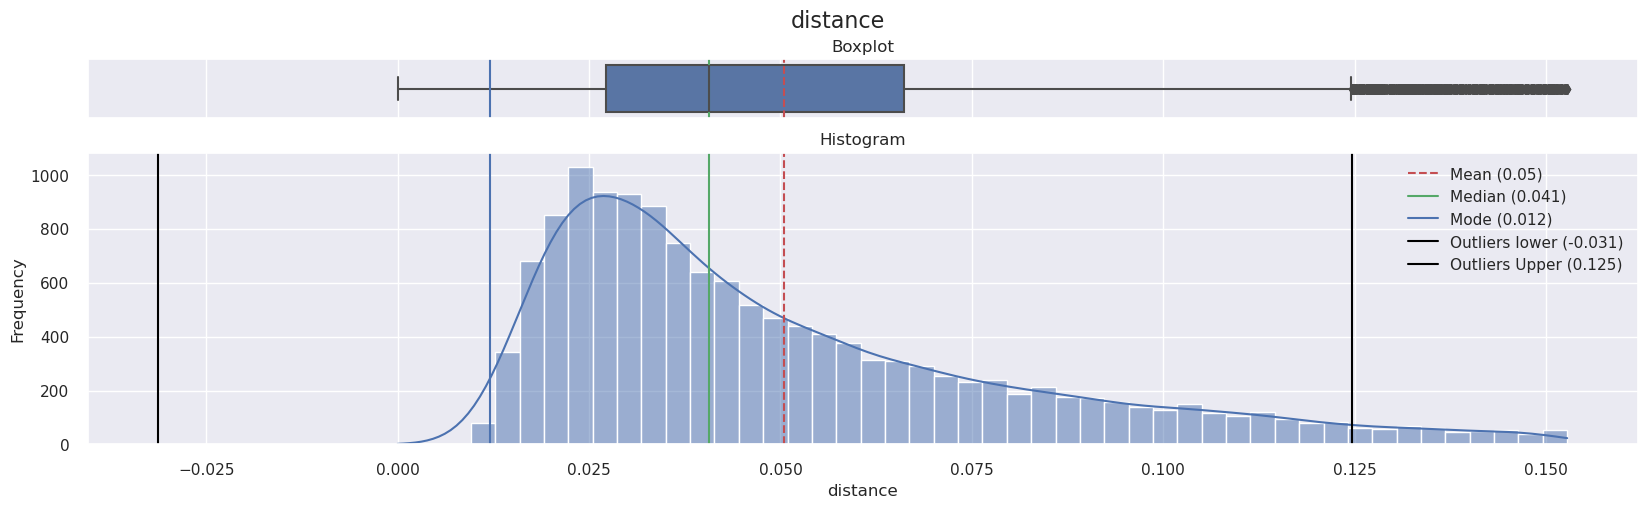

In [20]:
describe_num_var(similars_df, 'distance')

**Observaciones**

* Si visualizamos ls distribucion de distancias de todos los items al item en cuestión, se aprecia que es una distrubución sesgada a izquierda, es decir que los datos se concentran a izquierda.
* La moda es menor a la media dado que hay una concetracion de valores menos tipicos a derecha que empizan a al meda a derecha. La Moda se encuentra a la zquierca de la emdia ya que en ese sector se contrentra la mayor cantidad de valores.
* Esto no dice que hay mas items cercanos que lejanos. Esto item lejanos podemos verlos como valores atipicos, ya que el centro de la districion se encuentra mas cercano al item buscado.

In [21]:
genres_similars_df = filter_by_geners(similars_df, ['animation', 'adventure', 'children'])
genres_similars_df.head()

,distance,rating,id,title,genres,release
0,0.000000,3.806931,1,Toy Story,"[adventure, animation, children, comedy, fantasy]",1995
13166,0.010800,3.826316,8961,"Incredibles, The","[action, adventure, animation, children, comedy]",2004
1744,0.013183,3.000000,128540,The Gruffalo's Child,"[adventure, animation, children, fantasy]",2011
4818,0.014271,3.587302,2355,"Bug's Life, A","[adventure, animation, children, comedy]",1998
3715,0.014928,3.727273,166461,Moana,"[adventure, animation, children, comedy, fantasy]",2016


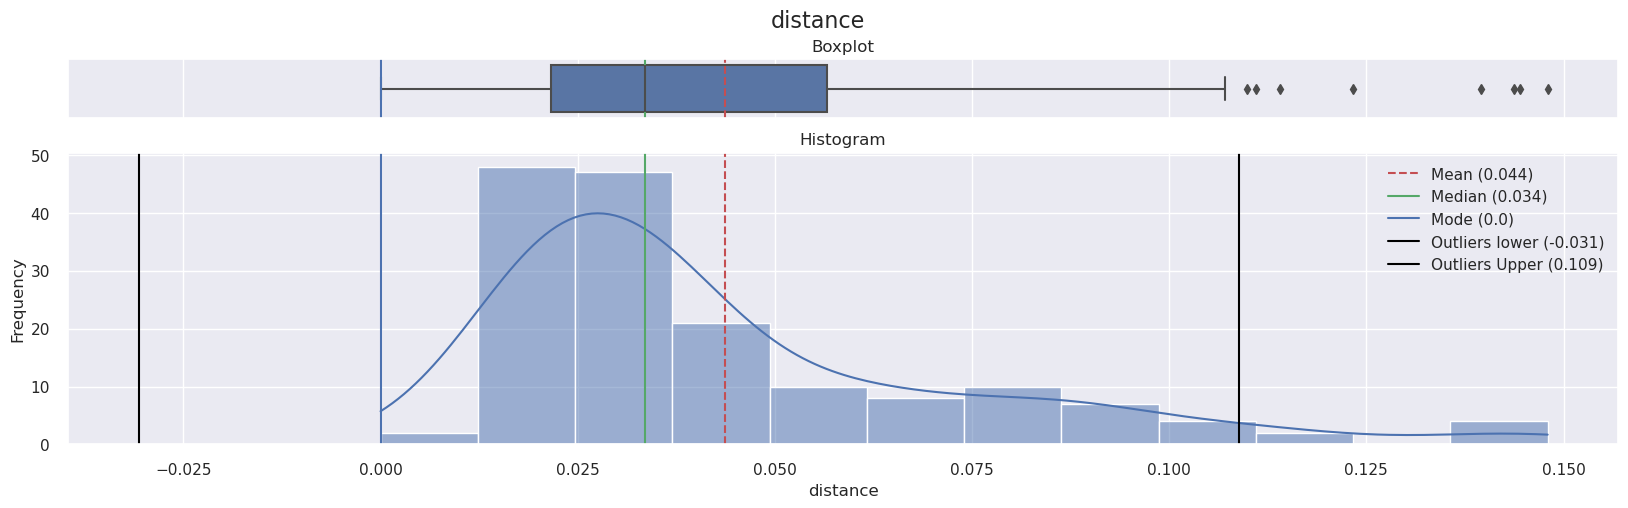

In [22]:
describe_num_var(genres_similars_df, 'distance')

**Observaciones**
 
    
* Si acotamos la districión a los items mas similares al item en cuestión vemos que la mediana de las distnacias es de 0.025. Esto nos dice que los items de generos similares se encuentra a la izquierda de la media del la districión de la figura anterior. 

Terminator Genisys

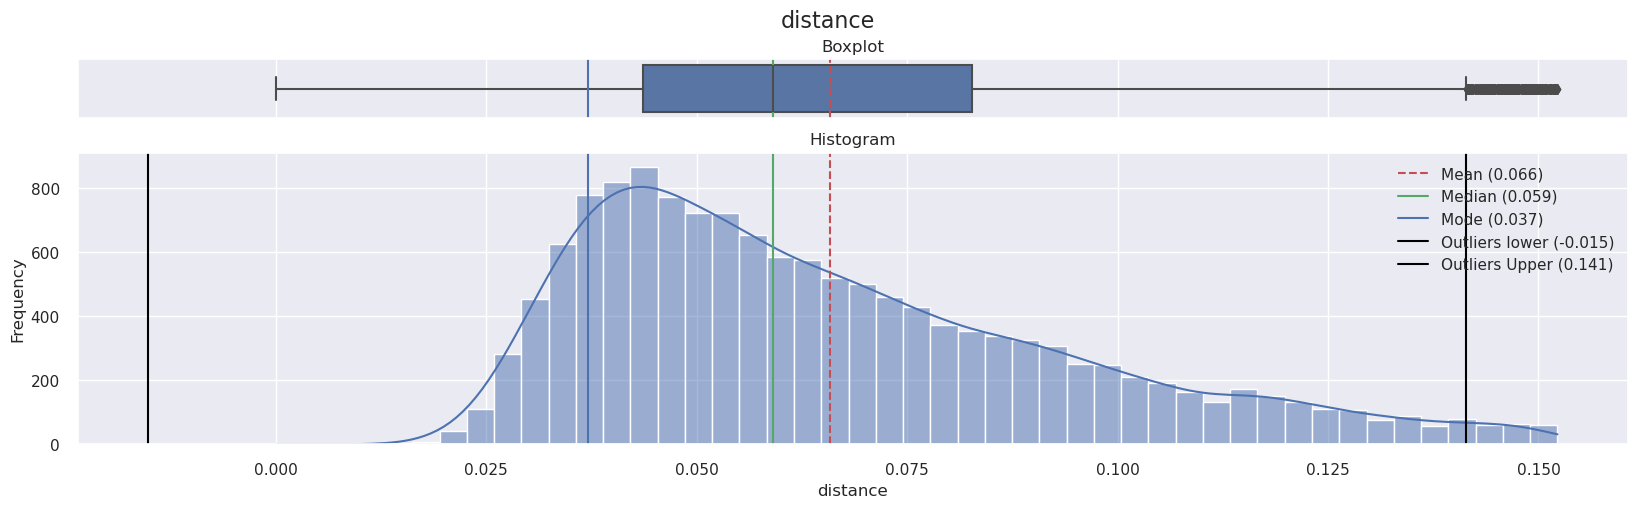

In [23]:
similars_df2 = await similars('Terminator', limit=14000)

describe_num_var(similars_df2, 'distance')

In [24]:
genres_similars_df2 = filter_by_geners(similars_df2, ['action', 'adventure', 'sci-fi', 'thriller'])
genres_similars_df2.head()

,distance,rating,id,title,genres,release
1416,0.000000,2.692308,120799,Terminator Genisys,"[action, adventure, sci-fi, thriller]",2015
3080,0.017429,2.772727,1544,"Lost World: Jurassic Park, The","[action, adventure, sci-fi, thriller]",1997
10006,0.020959,3.133333,61248,Death Race,"[action, adventure, sci-fi, thriller]",2008
10591,0.023415,2.000000,66639,Street Fighter: The Legend of Chun-Li,"[action, adventure, sci-fi, thriller]",2009
6557,0.026907,3.018868,34048,War of the Worlds,"[action, adventure, sci-fi, thriller]",2005


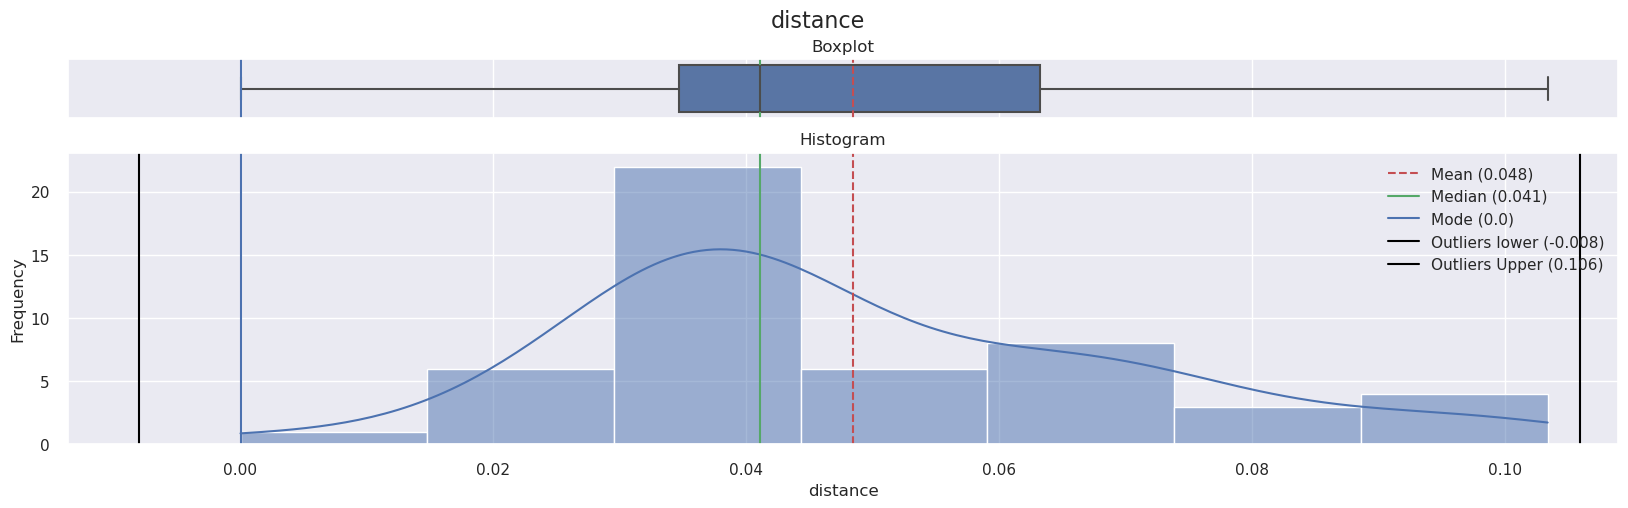

In [25]:
describe_num_var(genres_similars_df2, 'distance')

**Observaciones**

En resumen, los embeddings que representan a los items aprendidos por el modelo a apartir de las calificaciones de los usuario, parecen 
haber captado similitud por generos. Ya que idesm con generosmas similares parece ser ams sercanos al item en cuestión. 
Por supuesto que esto no es una relación directa, pero en ambos casos la media de los items con generos similares parecen estar a izquierda de la distribución no filtrada por generos. 